# Исследование объявлений о продаже квартир

В моём распоряжении оказались данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Моей адачей является установить параметры, влияющие на целевой признак. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Данные предоставлены в файле 'real_estate_data.csv'.

Таким образом, исследование можно разбить на следующие этапы:
- Обзор данных
- Предобработка
- Анализ

In [1]:
#импорт библиотек
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#задание стиля диаграмм
mpl.style.use(['Solarize_Light2'])

### Загрузка и ознакомление с данными

Для начала, импортирую датасет и получу общую информацию по нему.

In [3]:
path_01 = '/dataseets/real_estate_data.csv'
path_02 = 'https://code.s3.yandex.net/datasets/real_estate_data.csv'

In [4]:
try:
    if os.path.exists(path_01):
        data = pd.read_csv(path_01, sep='\t')
    elif os.path.exists(path_02):
        data = pd.read_csv(path_02, sep='\t')
    data.info(memory_usage='deep')
    display(data.head())
except:
    print('Возникла проблема при попытке загрузки датасета')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Уже сейчас видно много столбцов с пропущенными значениями. С их природой будем разбираться позднее.

Описание данных:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — общая площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

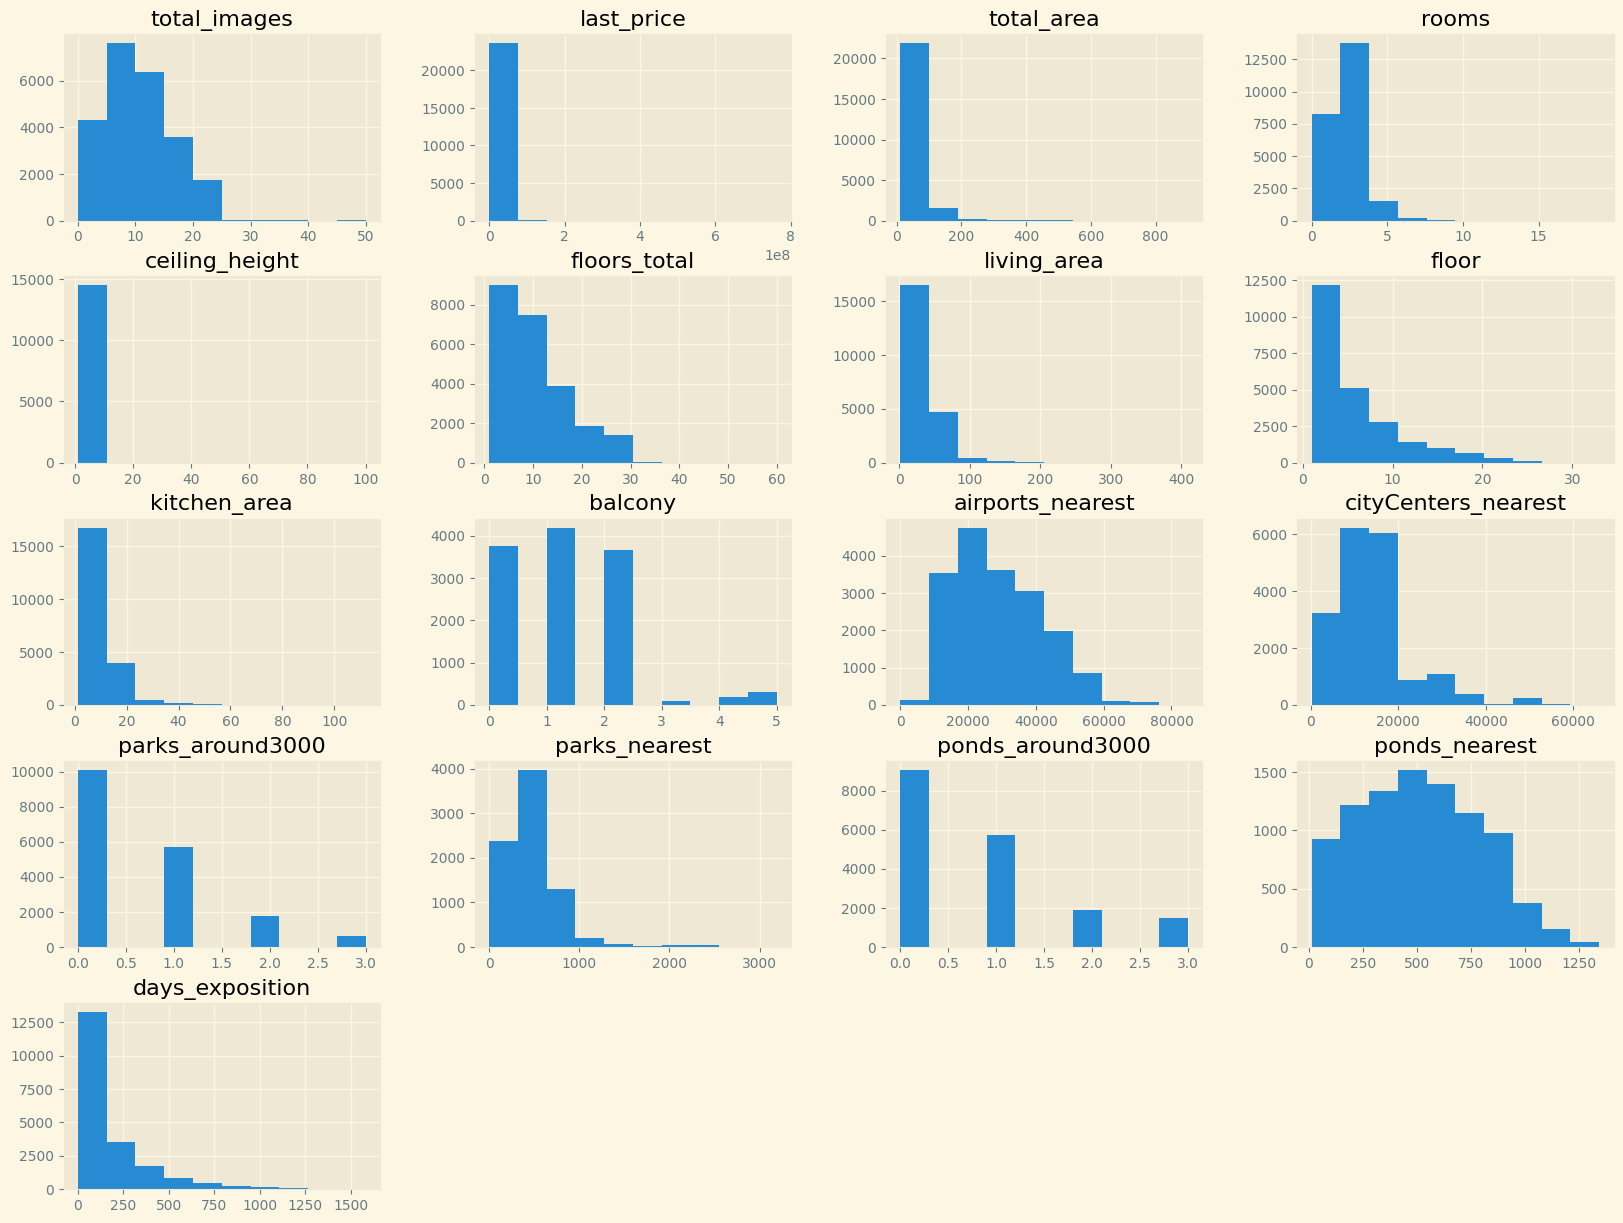

In [5]:
data.hist(figsize=(20, 15))
plt.show()

Большинство столбцов примерно соответствуют распределению Пуассона, либо тяготеют к нормальному распределению.

В некоторых гистограммах невооружённым взглядом видны выбросы, от которых скорее всего придётся избавиться.

### Предобработка данных

Для проведения анализа необходимы чистые данные, лишённые пропусков и дубликатов. Именно ими я сейчас и займусь.

#### Обработка пропусков

Для начала, определю в каких столбцах есть пропуски.

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Похоже, пропущенных значений довольно много. Особенно страдает столбец is_apartment, в котором заполнены всего 1/10 строк.

##### ceiling_height

Начну разбираться с пропусками с наиболее заполненных столбцов. Посмотрим на ceiling_height.
Возьму медиану оставшихся значений и поставлю на место NaN.

In [7]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Убедимся, что NaN в столбце ceiling_height не осталось.

In [8]:
data['ceiling_height'].isna().sum()

0

##### floors_total

Следующий на очереди столбец — floors_total, отражающий количество этажей в доме. Здесь, как и в первом случае, в пропущенных значениях виноват человеческий фактор: пользователи вводят некорректные значения, которые плохо обрабатываются и заменяются на NaN.

In [9]:
data['floors_total'].isna().sum()

86

Пропусков тут всего 86, потому их я спокойно удалю.

In [10]:
data = data.dropna(subset=['floors_total']).reset_index(drop=True)

Все пропуски успешно были удалены.

##### living_area

Далее, перейдём к столбцу living_area — жилой площади. Здесь пропуски также вероятно из-за некорректного ввода со стороны пользователя.

Предполагаю, что данный параметр может оказывать влияние за стоимость квартиры, и замена пропусков медианой может привести к некорректности дальнейших исследований. Проверим, так ли это.

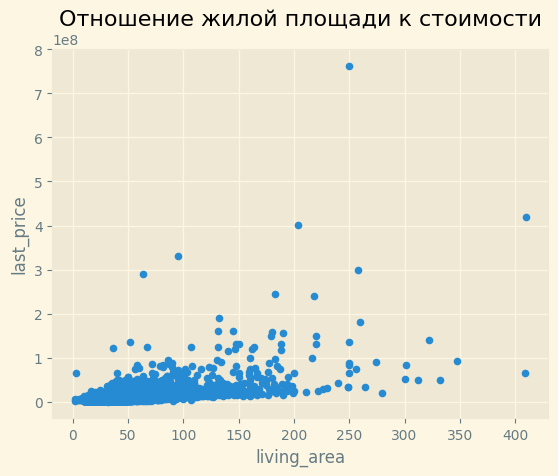

In [11]:
data.plot(x='living_area', y='last_price', kind='scatter', grid=True, title='Отношение жилой площади к стоимости');

Тут уже прослеживается некая зависимость, а значит, просто закрыть все пустующие значения медианой может оказаться не самым лучшим решением. Думаю, оптимальным вариантом будет сгруппировать квартиры по категории стоимости, и считать медиану уже для каждой из групп отдельно.

In [12]:
def categorize_price(price):
    if price <= 4000000:
        return 'D'
    elif price <= 6000000:
        return 'C'
    elif price <= 10000000:
        return 'B'
    else:
        return 'A'

In [13]:
data['price_category'] = data['last_price'].apply(categorize_price)

In [14]:
data['price_category'].value_counts()

D    9070
C    7249
B    4588
A    2706
Name: price_category, dtype: int64

Мы успешно разбили строки на категории стоимости по следующим правилам:
- до 4000,000 — `'D'`;
- 4000,001–6000,000 — `'C'`;
- 6000,001–10,000,000 — `'B'`;
- от 10,000,001 — `'A'`.

Теперь посчитаем медианные значения площади для каждой из них, и заменим NaN.

In [15]:
data.groupby('price_category')['living_area'].median()
#посмотрим медианные значения, чтобы убедиться в наличии зависимости

price_category
A    60.0
B    41.0
C    30.0
D    19.0
Name: living_area, dtype: float64

In [16]:
med = data.groupby('price_category')['living_area'].transform('median')
data['living_area'] = data['living_area'].fillna(med)
data['living_area'].isna().sum()

0

Пропущенных значений не осталось, можно переходить к следующему параметру.

##### is_apartment

В данном столбце можно предположить, что пользователи не указывали данную информацию, потому что их квартира — не апартаменты. Потому просто заменим все значения NuN на False

In [17]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

##### kitchen_area

С площадью кухни поступим также, как с жилой площадью. Проверю наличие зависимости площади от цены, посчитав медианы площади кухни для категорий стоимости, определённых в пп. 2.3.

In [18]:
data.groupby('price_category')['kitchen_area'].median()

price_category
A    16.0
B    11.0
C     9.0
D     8.0
Name: kitchen_area, dtype: float64

Видна тенденция на увеличение медианной площади с увеличением категории. Теперь я могу заменить пропуски медианами, как я делала это ранее.

In [19]:
med = data.groupby('price_category')['kitchen_area'].transform('median')
data['kitchen_area'] = data['kitchen_area'].fillna(med)
data['kitchen_area'].isna().sum()

0

##### balcony

Данный столбец отражает количество балконов и лоджий в квартире. Вероятно, незаполненные значения означают отсутствие балконов, а потому заполню их нулями.

In [20]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

##### locality_name

В данном столбце обозначены названия населённых пунктов. Вероятно, пользователи пропускали ввод данного параметра, считая его не важным. Невозможно определить, в каком населённом пункте находятся строки с пропущенными значениями, но поскольку их всего 49, я могу достаточно безопасно их удалить.

In [21]:
data = data.dropna(subset=['locality_name']).reset_index(drop=True)
data['locality_name'].isna().sum()

0

##### airports_nearest

Данный столбец отражает расстояние до аэропорта. В отличие от предыдущих, он рассчитывается автоматически, и тут ошибка может быть связана, например, с некорректно введённым адресом.

In [22]:
data['airports_nearest'].isna().sum()

5524

К сожалению, пропусков в данном столбце слишком много, но и восстановить данные я пока не могу. Замена медианой может исказить дальнейшие вычисления. Потому, придётся оставить данный параметр, как он есть.

##### cityCenters_nearest

Здесь у нас указывается расстояние до центра города. Как и в пункте ранее, посмотрим количество пропусков:

In [23]:
data['cityCenters_nearest'].isna().sum()

5501

##### parks_around3000 и parks_nearest

Эти два столбца взаимосвязаны, и потому имеет смысл рассматривать их вместе. Посмотрим на их значения:

In [24]:
data[['parks_around3000', 'parks_nearest']].head(20).sort_values(by='parks_around3000')

,parks_around3000,parks_nearest
19,0.0,NaN
1,0.0,NaN
17,0.0,NaN
14,0.0,NaN
6,0.0,NaN
7,0.0,NaN
9,0.0,NaN
11,0.0,NaN
15,1.0,590.0
13,1.0,294.0


Как можно увидеть по данному срезу данных, пропуски здесь имеют свой смысл. Пропуски в расстояниях до ближайщего парка стоят в том случае, если в столбце в количеством парков стоит 0 или NaN. NaN в первом столбце, в свою очередь, может означать отсутствие парков. Таким образом, и там, и там, можно просто заменить все NaN на 0.

In [25]:
data[['parks_around3000', 'parks_nearest']] = data[['parks_around3000', 'parks_nearest']].fillna(0)
data[['parks_around3000', 'parks_nearest']].isna().sum()

parks_around3000    0
parks_nearest       0
dtype: int64

##### ponds_around3000 и ponds_nearest

Для этих двух стобцов справедливо всё то же, что и для предыдущих. Вновь заменяю все NaN на 0.

In [26]:
data[['ponds_around3000', 'ponds_nearest']] = data[['ponds_around3000', 'ponds_nearest']].fillna(0)
data[['ponds_around3000', 'ponds_nearest']].isna().sum()

ponds_around3000    0
ponds_nearest       0
dtype: int64

##### days_exposition

Данный столбец отражает, сколько дней квартира выставлена на продажу. Предположительно, NaN здесь могут стоять вместо 0. Проверим эту гипотезу, посчитав количество нулей в столбце.

In [27]:
data.query('days_exposition == 0')['days_exposition']

Series([], Name: days_exposition, dtype: float64)

И действительно, в данном столбце нулей не существует, а значит, предположение вполне справедливо и мы можем заменить все пустующие значения на 0.

In [28]:
data['days_exposition'] = data['days_exposition'].fillna(0)

##### Промежуточный вывод

Проверим, остались ли ещё в нашем датафрейме пропущенные значения:

In [29]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5524
cityCenters_nearest     5501
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition            0
price_category             0
dtype: int64

Напротив каждого столбца кроме дистанции до центра и до аэропорта стоят нули, а значит мы успешно устранили пропущенные значения. Теперь можно перейти к проверке типов данных.

#### Изменение типов данных

Для начала, посмотрим типы данных столбцов.

In [30]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

##### first_day_exposition

Изменю формат даты-времени в данном столбце, чтобы осталась только дата, поскольку в данный момент на месте времени стоят нули. Предположительно это произошло из-за автоматического преобразования типа данных в той программе, где этот датасет ранее был создан или изменён.

In [31]:
data['first_day_exposition'].head(1) #старый формат

0    2019-03-07T00:00:00
Name: first_day_exposition, dtype: object

In [32]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition']).dt.date
data['first_day_exposition'].head(1) #новый формат

0    2019-03-07
Name: first_day_exposition, dtype: object

Как видно, данные изменились: теперь в них нет "Т00:00:00". Можем двигаться дальше.

##### float в int

В данном датасете есть несколько значений с плавающей точкой, которые должны содержать в себе исключительно целочисленные объекты: 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition'. Их я преобразую в int.

In [33]:
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')
data['days_exposition'] = data['days_exposition'].astype('int64')
data[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']].head()

,floors_total,balcony,parks_around3000,ponds_around3000,days_exposition
0,16,0,1,2,0
1,11,2,0,0,81
2,5,0,1,2,558
3,14,0,2,3,424
4,14,0,2,1,121


Как видим, столбцы успешно сменили свои типы и теперь являются целочисленными.

##### Оптимизация числовых типов данных

В датасете большинство столбцов хранят числовые типы данных: float64 и int64. 64 тут означает, что каждое хранимое в них значение занимает 64 байта, что неоправданно много. Но можно уменьшить занимаемое ими пространство, и тем самым немного ускорить работу с датафреймом.

In [34]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  int64  
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Запомним значение "memory_usage" — 7.8 MB, чтобы затем сравнить его со значением после преобразования.

Преобразовываю целочисленные столбцы:

In [35]:
# total_images rooms floors_total floor parks_around3000 ponds_around3000 days_exposition
# last_price total_area ceiling_height living_area kitchen_area airports_nearest cityCenters_nearest parks_nearest ponds_nearest
cols_to_int = ['total_images', 'rooms', 'floors_total', 'floor', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']
for col in cols_to_int:
    data[col] = pd.to_numeric(data[col], downcast='integer')
    print(col, data[col].dtypes)

total_images int8
rooms int8
floors_total int8
floor int8
balcony int8
parks_around3000 int8
ponds_around3000 int8
days_exposition int16


Все столбцы типа int64 были понижены до оптимальных. Теперь проделаю то же самое с float.

In [36]:
cols_to_float = ['last_price', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area',
                 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], downcast='float')
    print(col, data[col].dtypes)

last_price float32
total_area float32
ceiling_height float32
living_area float32
kitchen_area float32
airports_nearest float32
cityCenters_nearest float32
parks_nearest float32
ponds_nearest float32


Посмотрим, как эти преобразования отразились на параметре memory_usage:

In [37]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int8   
 1   last_price            23565 non-null  float32
 2   total_area            23565 non-null  float32
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int8   
 5   ceiling_height        23565 non-null  float32
 6   floors_total          23565 non-null  int8   
 7   living_area           23565 non-null  float32
 8   floor                 23565 non-null  int8   
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float32
 13  balcony               23565 non-null  int8   
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Как видите, нам удалось сэкономить 2 Мегабайта.

##### Промежуточный вывод

Я изменила формат datetime на date в столбце first_day_exposition, поскольку время в нём не было указано;
Преобразовала float в int там, где это имело смысл;
Уменьшила выделяемый объём памяти для числовых типов.
Всё это в сумме дало более оптимизированный датафрейм, который занимает меньше памяти и не несёт в себе лишней информации.

#### Обработка неявных дубликатов

В данном датафрейме явных дубликатов у нас нет, что можно подтвердить следующим методом:

In [38]:
data.duplicated().sum()

0

Но в столбце locality_name, где у нас хранятся населённые пункты, находится множество неявных дубликатов. Посмотрим на них, выведя уникальные значения столбца в алфавитном порядке.

In [39]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Список довольно большой, но характер дублирования ясен: некоторые пользователи вводят "поселок городского типа Большая Ижора", а некоторые "городской поселок Большая Ижора". Очевидно, это одно и то же место. Необходимо привести все названия к единому формату, чтобы не возникало проблем при дальнейшем анализе.

Моя идея состоит в следующем: заменить все "ё" на "е", "городской поселок" на "поселок городского типа", "поселок станции" на "поселок". Делать это всё я буду на дубликате столбца locality_name, который назовём locality_name_cleared

In [40]:
data['locality_name_cleared'] = data['locality_name']

Начну с замены ё на е:

In [41]:
data['locality_name_cleared'] = data['locality_name_cleared'].str.replace('ё', 'е')
data['locality_name_cleared'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Советский', 'городской поселок Фед

Как видим, "ё" в нашем списке больше нет, и теперь можно перейти к замене "городской поселок" на "поселок городского типа":

In [42]:
data['locality_name_cleared'] = data['locality_name_cleared'].str.replace('городской поселок', 'поселок городского типа')
data['locality_name_cleared'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

И наконец, меняю "поселок станции" и "поселок при железнодорожной станции" на "поселок":

In [43]:
data['locality_name_cleared'] = data['locality_name_cleared'].str.replace('поселок станции', 'поселок')
data['locality_name_cleared'] = data['locality_name_cleared'].str.replace('поселок при железнодорожной станции', 'поселок')
data['locality_name_cleared'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

Я успешно удалила дублировавшие друг друга поселки.

#### Промежуточный вывод
Таким образом, я избавилась от пустых значений, заменила тип данных там, где это было необходимо, и там, где возможно с целью оптимизации, и устранила неявные дубликаты.

### Добавление новых столбцов

#### Добавление столбца "Цена одного кваратного метра"

Данный столбец я получу посредством деления стоимости продажи на общую площадь.

In [44]:
data['meter_price'] = (data['last_price'] / data['total_area']).round(2)

In [45]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,18863.0,16028.0,1,482.0,2,755.0,0,A,Санкт-Петербург,120370.367188
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,12817.0,18603.0,0,0.0,0,0.0,81,D,поселок Шушары,82920.789062
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,21741.0,13933.0,1,90.0,2,574.0,558,C,Санкт-Петербург,92785.710938
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,60.000000,9,False,...,28098.0,6800.0,2,84.0,3,234.0,424,A,Санкт-Петербург,408176.093750
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,31856.0,8098.0,2,112.0,1,48.0,121,B,Санкт-Петербург,100000.000000


#### Добавление столбца "День недели"

In [46]:
data['weekday'] = pd.to_datetime(data['first_day_exposition']).apply(lambda x: x.weekday())
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price,weekday
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,16028.0,1,482.0,2,755.0,0,A,Санкт-Петербург,120370.367188,3
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,18603.0,0,0.0,0,0.0,81,D,поселок Шушары,82920.789062,1
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,13933.0,1,90.0,2,574.0,558,C,Санкт-Петербург,92785.710938,3
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,60.000000,9,False,...,6800.0,2,84.0,3,234.0,424,A,Санкт-Петербург,408176.093750,4
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,8098.0,2,112.0,1,48.0,121,B,Санкт-Петербург,100000.000000,1


#### Добавление столбца "Месяц публикации"

In [47]:
data['month'] = pd.to_datetime(data['first_day_exposition']).dt.month
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price,weekday,month
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,1,482.0,2,755.0,0,A,Санкт-Петербург,120370.367188,3,3
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,0,0.0,0,0.0,81,D,поселок Шушары,82920.789062,1,12
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,1,90.0,2,574.0,558,C,Санкт-Петербург,92785.710938,3,8
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,60.000000,9,False,...,2,84.0,3,234.0,424,A,Санкт-Петербург,408176.093750,4,7
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,2,112.0,1,48.0,121,B,Санкт-Петербург,100000.000000,1,6


#### Добавление столбца "Год публикации"

In [48]:
data['year'] = pd.to_datetime(data['first_day_exposition']).dt.year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price,weekday,month,year
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,0,A,Санкт-Петербург,120370.367188,3,3,2019
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,0,0.0,81,D,поселок Шушары,82920.789062,1,12,2018
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,90.0,2,574.0,558,C,Санкт-Петербург,92785.710938,3,8,2015
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,60.000000,9,False,...,84.0,3,234.0,424,A,Санкт-Петербург,408176.093750,4,7,2015
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121,B,Санкт-Петербург,100000.000000,1,6,2018


#### Добавление столбца "Тип этажа"
Здесь я выделю, находится ли кварира на первом этаже, последнем или каком-либо между ними.

In [49]:
def categorize_floor(floor, floors_total):
    if floor == 1:
        return 'Первый'
    elif floor == floors_total:
        return 'Последний'
    else:
        return 'Другой'

In [50]:
data['floor_type'] = data.apply(lambda x: categorize_floor(x['floor'], x['floors_total']), axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price,weekday,month,year,floor_type
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,2,755.0,0,A,Санкт-Петербург,120370.367188,3,3,2019,Другой
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,0,0.0,81,D,поселок Шушары,82920.789062,1,12,2018,Первый
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,2,574.0,558,C,Санкт-Петербург,92785.710938,3,8,2015,Другой
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,60.000000,9,False,...,3,234.0,424,A,Санкт-Петербург,408176.093750,4,7,2015,Другой
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,1,48.0,121,B,Санкт-Петербург,100000.000000,1,6,2018,Другой


#### Добавление столбца "Расстояние до центра в километрах"

In [51]:
data['cityCenters_km'] = (data['cityCenters_nearest'] / 1000).round()
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price,weekday,month,year,floor_type,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,755.0,0,A,Санкт-Петербург,120370.367188,3,3,2019,Другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,81,D,поселок Шушары,82920.789062,1,12,2018,Первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,574.0,558,C,Санкт-Петербург,92785.710938,3,8,2015,Другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,60.000000,9,False,...,234.0,424,A,Санкт-Петербург,408176.093750,4,7,2015,Другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,48.0,121,B,Санкт-Петербург,100000.000000,1,6,2018,Другой,8.0


### Исследовательский анализ данных

#### Изменение и удаление выбросов

По гистограммам, построенным для всех столбцов в п. 1 уже можно с уверенностью сказать, что в данных хватает выбросов. Это могут быть некорректно введённые данные или действительно редкие, но правдивые значения.

##### total_area

Начну с параметра, обозначающего общую площадь квартиры. Построю гистограмму чтобы определить, где сгруппированы все значения, а где начинаются выбросы.

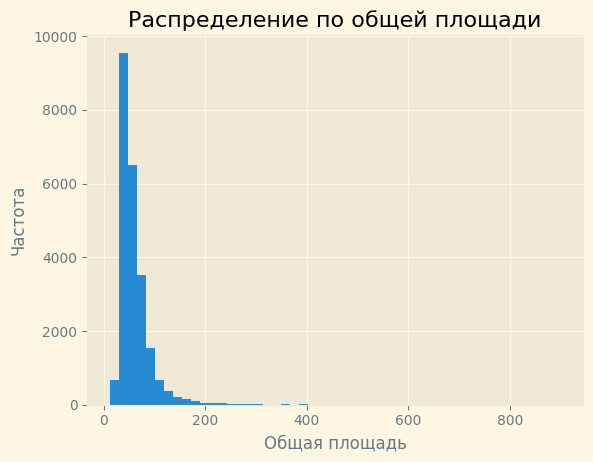

In [52]:
plt.hist(data['total_area'], bins=50)
plt.title('Распределение по общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Частота')
plt.show()

По графику выше можно сделать вывод, что значений выше 400 кв.м. настолько мало, что их удаление вполне допустимо.

In [53]:
data = data.drop(data[data['total_area'] >= 400].index)

##### living_area

Посмотрим на выпадающие значения:

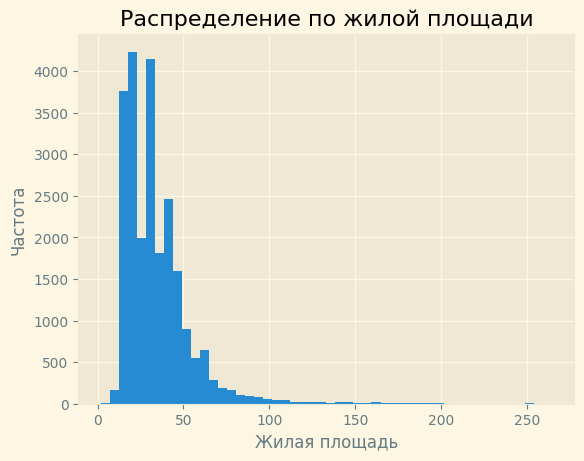

In [54]:
plt.hist(data['living_area'], bins=50)
plt.title('Распределение по жилой площади')
plt.xlabel('Жилая площадь')
plt.ylabel('Частота')
plt.show()

В данной ситуации удалю всё, что больше 200 кв.м.

In [55]:
data = data.drop(data[data['living_area'] >= 200].index)

##### kitchen_area

С параметром площади кухни поступлю аналогично: визуально определю наиболее отдалённые значения.

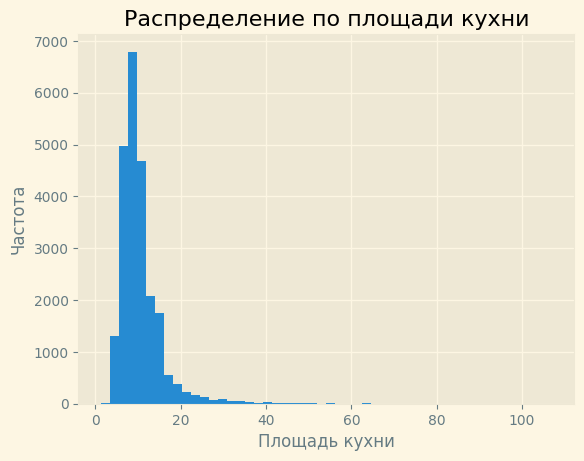

In [56]:
plt.hist(data['kitchen_area'], bins=50)
plt.title('Распределение по площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Частота')
plt.show()

Удалю то, что выше 80 кв.м.

In [57]:
data = data.drop(data[data['kitchen_area'] >= 80].index)

##### last_price

Посмотрим на гистограмму столбца со стоимостью квартир.

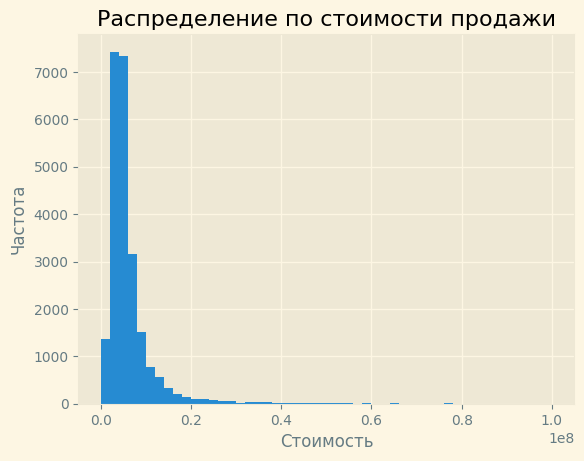

In [58]:
plt.hist(data['last_price'], bins=50, range=(0, 100000000))
plt.title('Распределение по стоимости продажи')
plt.xlabel('Стоимость')
plt.ylabel('Частота')
plt.show()

Квартиры стоимостью выше 50,000,000 практически не встречаются, а значит, их можно удалить.

In [59]:
data = data.drop(data[data['last_price'] >= 50000000].index)

##### rooms

Посмотрим на параметр количества комнат.

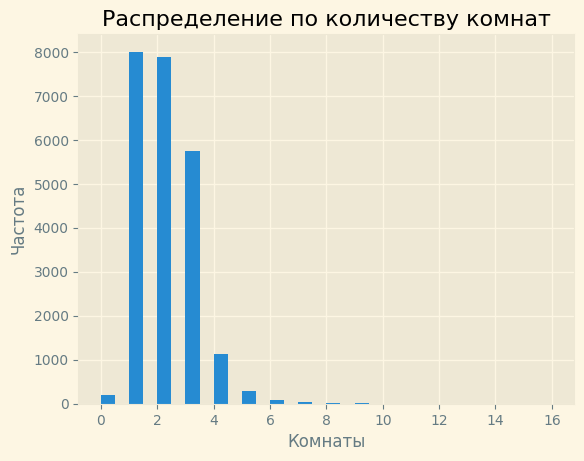

In [60]:
plt.hist(data['rooms'], bins=32)
plt.title('Распределение по количеству комнат')
plt.xlabel('Комнаты')
plt.ylabel('Частота')
plt.show()

Удалю те квартиры, где комнат указано 8 и более.

In [61]:
data = data.drop(data[data['rooms'] >= 8].index)

##### ceiling_height

В данном параметре у нас хранятся высоты потолков.

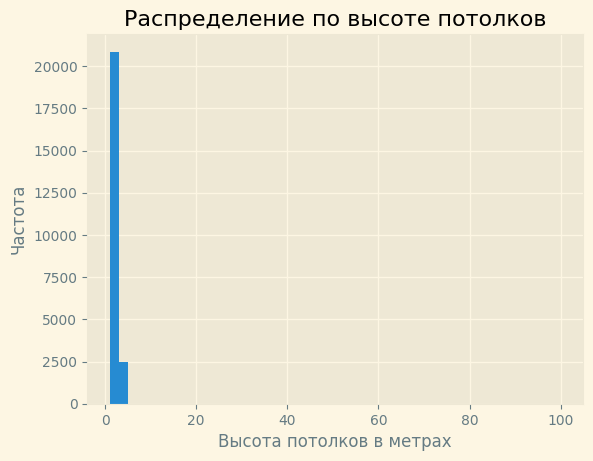

In [62]:
plt.hist(data['ceiling_height'], bins=50)
plt.title('Распределение по высоте потолков')
plt.xlabel('Высота потолков в метрах')
plt.ylabel('Частота')
plt.show()

Каким-то образом, у нас есть значения вплоть до сотни. Если в предыдущих параметрах можно было допустить, что существуют квартиры площадью, скажем, 400 метров, то высота потолка выше 10 метров кажется нереалистичной. Потому допустим, что при вводе была допущена ошибка, и значения с плавающей точкой были обработаны, как целые. Так что, возьму все значения выше 20 и умножу на 0.1.

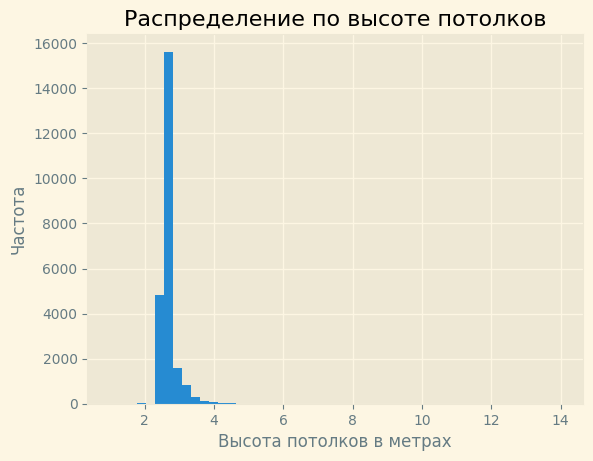

In [63]:
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] *= 0.1
plt.hist(data['ceiling_height'], bins=50)
plt.title('Распределение по высоте потолков')
plt.xlabel('Высота потолков в метрах')
plt.ylabel('Частота')
plt.show()

Видимо, у нас таже имеются значения ниже двух метров, чего для потолка быть не должно. Эти значения я удалю.

In [64]:
data = data.drop(data[data['ceiling_height'] <= 2].index)

##### floor_type

Данный столбец был создан мною и отражает тип этажа: "Первый", "Последний" и "Другой"

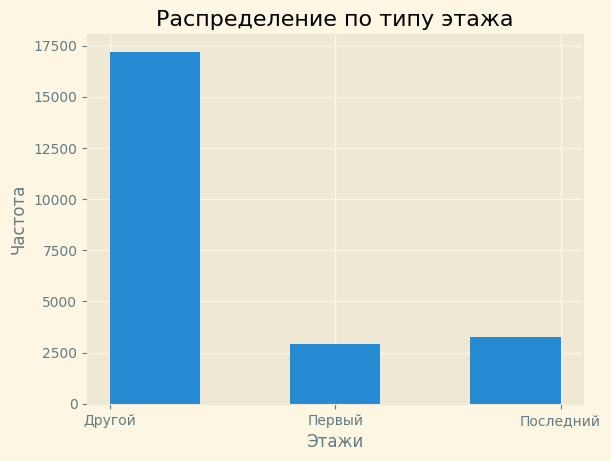

In [65]:
plt.hist(data['floor_type'], bins=5)
plt.title('Распределение по типу этажа')
plt.xlabel('Этажи')
plt.ylabel('Частота')
plt.show()

Как видим, квартир, расположенных не на первом и не на последнем этаже большинство, что вполне закономерно, ведь таких этажей гораздо больше. Также, квартир на последнем этаже немного больше, чем на первом. Возможно, это связано с тем, что на первых этажах зачастую распологаются нежелые помещения.

##### floors_total

Посмотрим на распределение по показателю всего этажей в доме.

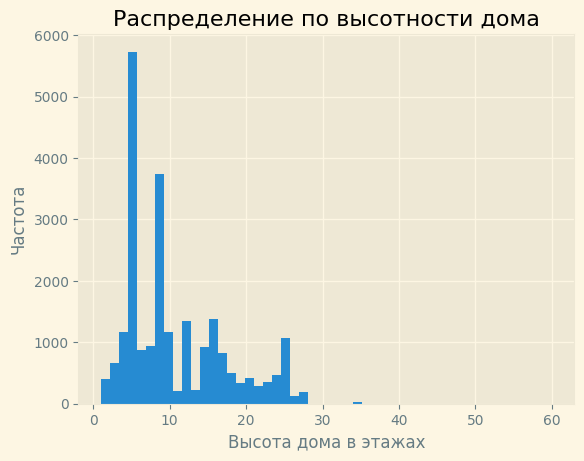

максимум: 60


In [66]:
plt.hist(data['floors_total'], bins=50)
plt.title('Распределение по высотности дома')
plt.xlabel('Высота дома в этажах')
plt.ylabel('Частота')
plt.show()
print('максимум:', data['floors_total'].max())

Тут уже распределение не такое нормальное, как в параметрах ранее. При этом, если сравнить с этажами, на которых расположена продаваемая квартира, то открывается совсем уж странная картина:

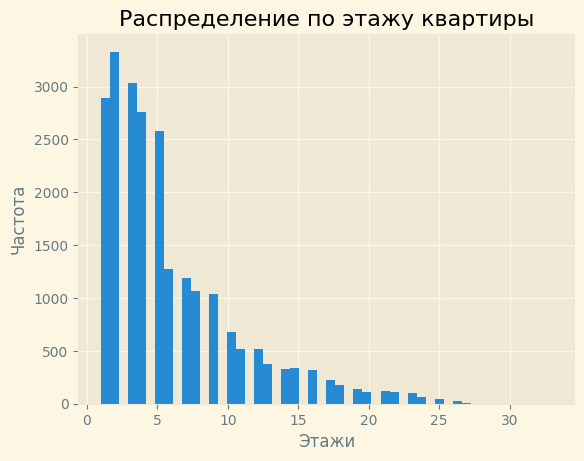

максимум: 33


In [67]:
plt.hist(data['floor'], bins=50)
plt.title('Распределение по этажу квартиры')
plt.xlabel('Этажи')
plt.ylabel('Частота')
plt.show()
print('максимум:', data['floor'].max())

Т.е. самая высоко расположенная квартира находится на 33 этаже, тогда как самый высокий дом имеет высоту в 60 этажей.

Тут можно предположить два варианта: ошибку ввода, как в случае с высотой потолка, в таком случае 60-этажный дом на самом деле 6-ти этажный. Либо что в самых высоких домах жители высоких этажей не желают продавать свои квартиры. И тот, и другой вариант выглядит странно, так что безопаснее всего будет удалить все квартиры, этажность зданий которых выше 35-ти.

In [68]:
data = data.drop(data[data['floors_total'] >= 35].index)

##### cityCenters_nearest

Рассмотрим параметр удалённости от центра.

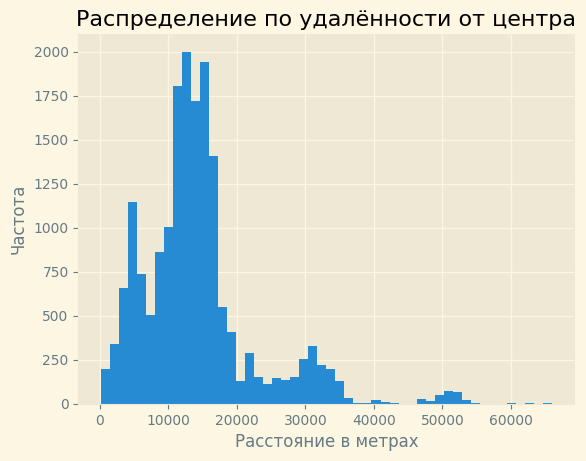

In [69]:
plt.hist(data['cityCenters_nearest'], bins=50)
plt.title('Распределение по удалённости от центра')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')
plt.show()

Видим, что большинство квартир располагается на расстоянии 15 км от центра своего населённого пункта, и также есть заметный подъём в районе 5 км.

Удалю то, что находится дальше 40 км: в нашей выборке нет населённых пунктов, в которых удалённость от центра может быть выше этого.

In [70]:
data = data.drop(data[data['cityCenters_nearest'] >= 40000].index)

##### parks_nearest

Данный параметр отражает расстояние до ближайшего парка в пределах 3000 метров.

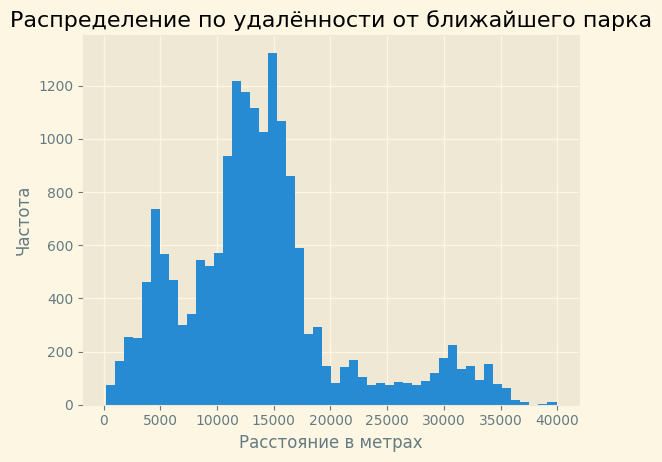

In [71]:
plt.hist(data['cityCenters_nearest'], bins=50)
plt.title('Распределение по удалённости от ближайшего парка')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')
plt.show()

Возвышение в районе нуля объяснимо тем, что это значение мы присвоили тем квартирам, у которых нет парков по близкости. В остальном, наблюдаем вполне нормальное распределение. Удалять здесь я буду то, что находится дальше 3000 метров, поскольку нас интересуют только парки в этом радиусе.

In [72]:
data = data.drop(data[data['parks_nearest'] > 3000].index)
data = data.reset_index(drop=True) #Восстанавливаем индексацию после всех удалений

##### Промежуточный вывод

Я разобралась со столбцами, в которых были какие-либо выбросы, и либо удалила наиболее редко встречающиеся и аномальные значения, либо исправила их, как в столбце "ceiling_height".

#### Насколько быстро продавались квартиры?

Для ответа на этот вопрос, рассмотрим данные из столбца "days_exposition"

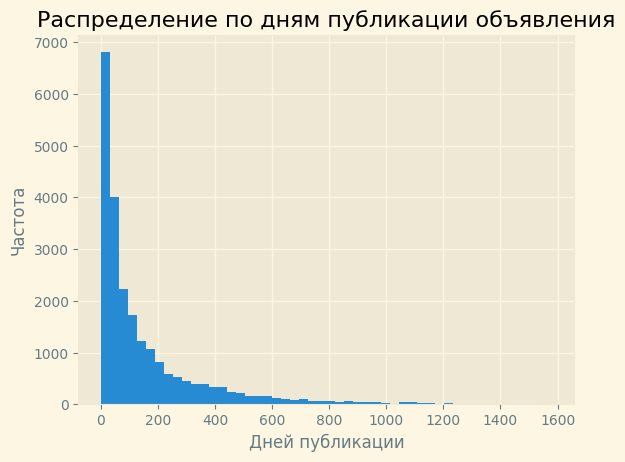

In [73]:
plt.hist(data['days_exposition'], bins=50)
plt.title('Распределение по дням публикации объявления')
plt.xlabel('Дней публикации')
plt.ylabel('Частота')
plt.show()

Видим распределение Пуассона: большинство квартир было продано в первые же дни после выкладки, хотя есть и рекордсмены, простаивавшие более четырёх лет.

Посчитаем среднее и медиану:

In [74]:
print('среднее =', data['days_exposition'].mean())
print('медиана =', data['days_exposition'].median())

среднее = 155.5292509330787
медиана = 73.0


Мы видим, что среднее сильно больше медианы — но это нормально для распределения Пуассона, ведь по гистограмме видно, что несмотря на большое скопление значений в начале, у нас есть довольно далёкие выбросы, которые и оттягивают среднее наверх. Более информативно будет смотреть на график boxplot — "ящик с усами":

Первый квартиль:  22.0
Третий квартиль:  196.0
Максимум, в соответствии с межквартильным расстоянием: 457.0


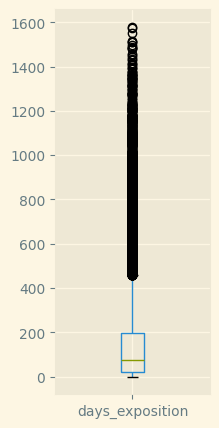

In [75]:
q_1 = data['days_exposition'].quantile(0.25) #Первый квартиль
q_3 = data['days_exposition'].quantile(0.75) #Третий квартиль
iqr = q_3 - q_1 #Межквартильное расстояние
print ('Первый квартиль: ', q_1)
print ('Третий квартиль: ', q_3)
print ('Максимум, в соответствии с межквартильным расстоянием:', (q_3 + iqr * 1.5))
data.boxplot('days_exposition', figsize=(2,5));

Как видно по данному графику, нормальные значения лежат в промежутке от 0 до 457 дней. Все объявления, пролежавшие дольше этой отметки, можно считать выбросами.

##### Промежуточный вывод

Можно сказать, что на редкость быстрые объявления — те, которые продались быстрее чем за 22 дня. Большинство объявлений находятся в промежутке от 22 до 196 дней. Допустимо, если объявление продалось в пределах 457 дней, всё, что далее — аномально долгое значение.

#### Какие факторы влияют на общую стоимость объекта?

В данном подразделе определим, какие из представленных далее параметров оказывают влияние на финальную стоимость квартиры.

##### Общая площадь

Необходимо выявить зависимость стоимости квартиры от её общей площади. Для этого я сгруппирую данные по площади, рассчитаю среднюю стоимость и выведу в виде гистограммы.

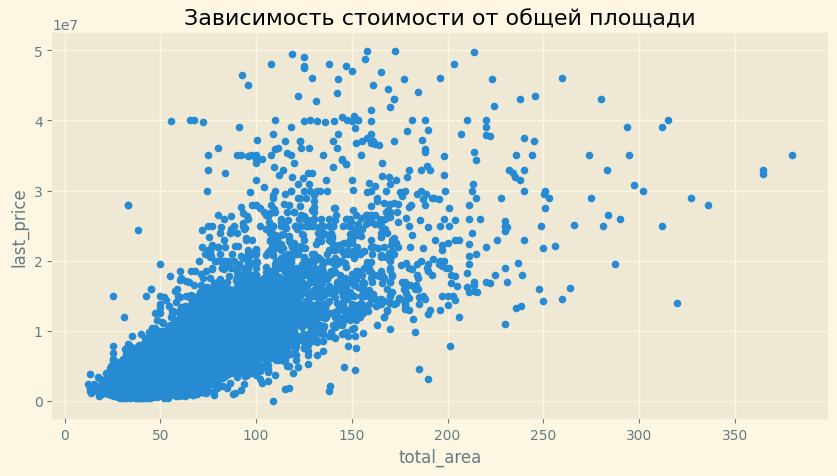

In [76]:
data.plot(x='total_area', y='last_price', kind='scatter', figsize=(10,5), grid=True, title='Зависимость стоимости от общей площади');

Зависимость совершенно очевидна. Определим её математически при помощи корреляции Пирсона.

In [77]:
data[['total_area', 'last_price']].corr()

,total_area,last_price
total_area,1.000000,0.781833
last_price,0.781833,1.000000


Выходит, корреляция между площадью и ценой равняется 0,78. Запомним это число, ведь в дальнейшем оно позволит нам определить, какие параметры оказывают наибольшее влияние.

##### Жилая площадь

Жилая площадь — это та площадь квартиры, которая состоит из жилых комнат. В неё не входят коридор, кухня, туалет, балкон и любые технические помещения.

Проверим, меняется ли средняя стоимость в зависимости от жилой площади квартиры.

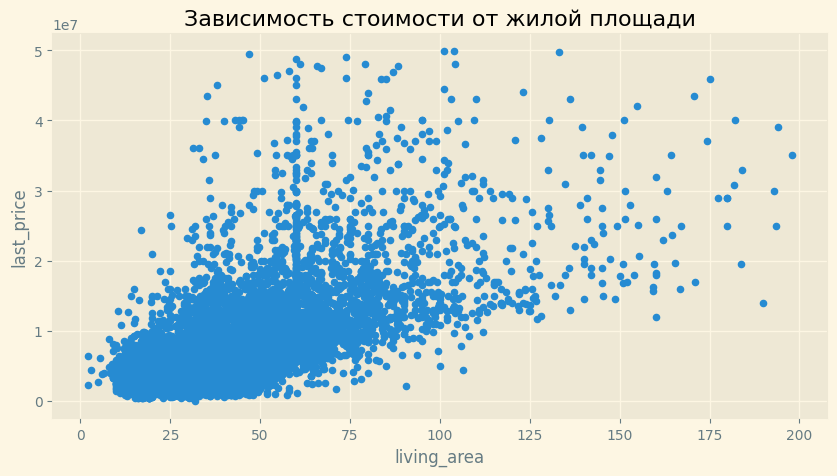

In [78]:
data.plot(x='living_area', y='last_price', kind='scatter', figsize=(10,5), grid=True, title='Зависимость стоимости от жилой площади');

И вновь зависимость тут совершенно логична и справедлива. Чем больше площадь жилых комнат, тем больше стоимость. Посмотрим на коэффициент корреляции.

In [79]:
data[['living_area', 'last_price']].corr()

,living_area,last_price
living_area,1.000000,0.685717
last_price,0.685717,1.000000


Как видно, в данном случае у нас коэффициент корреляции составляет 0.69, что меньше, чем у общей площади, но всё равно достаточно много.

##### Площадь кухни

Проверим, оказывает ли такое же влияние на цену площадь кухни.

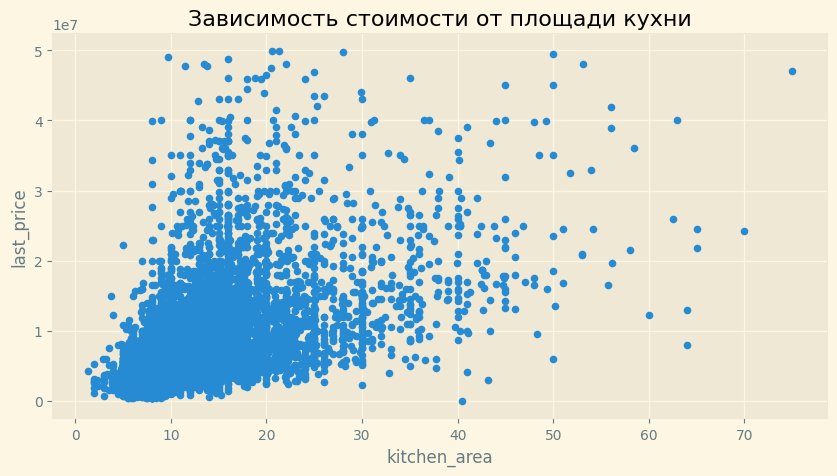

In [80]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(10,5), grid=True, title='Зависимость стоимости от площади кухни');

Данный график выглядит похоже на график с жилой площадью, но при этом более "сжат" к началу координат.

In [81]:
data[['kitchen_area', 'last_price']].corr()

,kitchen_area,last_price
kitchen_area,1.000000,0.606033
last_price,0.606033,1.000000


Благодаря коэффициенту корреляции мы теперь знаем, что кухня из всех прошедших трёх показателей оказывает наименьшее влияние на конечную стоимость.

##### Количество комнат

В отличие от показателей площади, этот параметр уже не настолько очевиден. Посмотрим, как распределяется стоимость по количеству комнат.

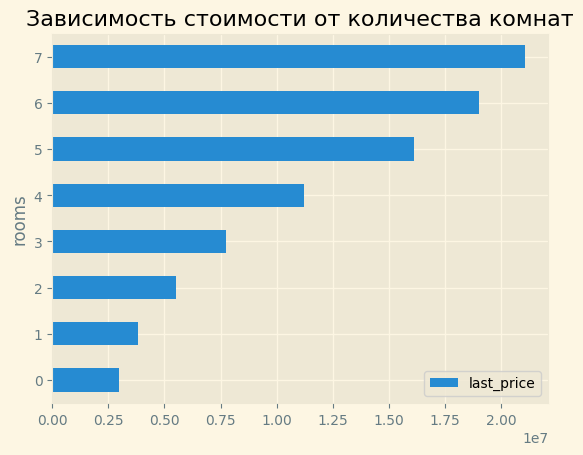

In [82]:
rooms_pivot = data.pivot_table(index='rooms', values='last_price')
rooms_pivot.plot.barh(grid=True, title='Зависимость стоимости от количества комнат');

In [83]:
data[['rooms', 'last_price']].corr()

,rooms,last_price
rooms,1.000000,0.496366
last_price,0.496366,1.000000


И действительно, здесь всё ещё достаточно заметная корреляция, но уже не такая сильная, как с параметрами площади.

##### Этаж, на котором расположена квартира

А именно категория "Первый", "Последний" или "Другой". Посмотрим, как отличается стоимость в этих трёх категориях.

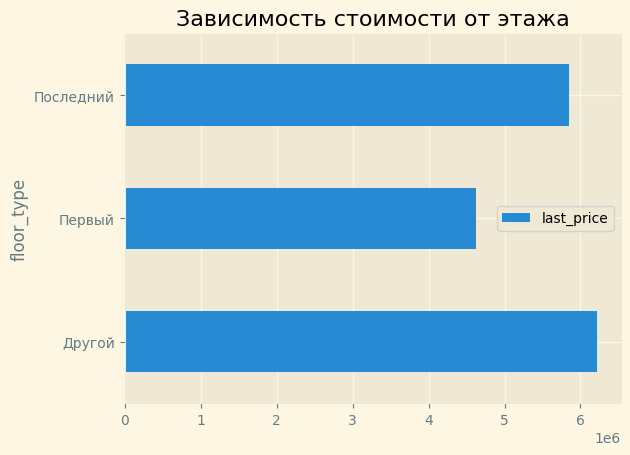

In [84]:
floor_pivot = data.pivot_table(index='floor_type', values='last_price', aggfunc='mean')
floor_pivot.plot.barh(grid=True, title='Зависимость стоимости от этажа');

Самое высокое среднее значение среди категории "Другой", где собраны этажи, не вошедшие в другие две категории. Меньше всего средняя стоимость у квартир на первом этаже.

##### Дата размещения

Проверим, как дата размещения объекта влияла на его стоимость. Пойдём от общего к частному: начнём с года.

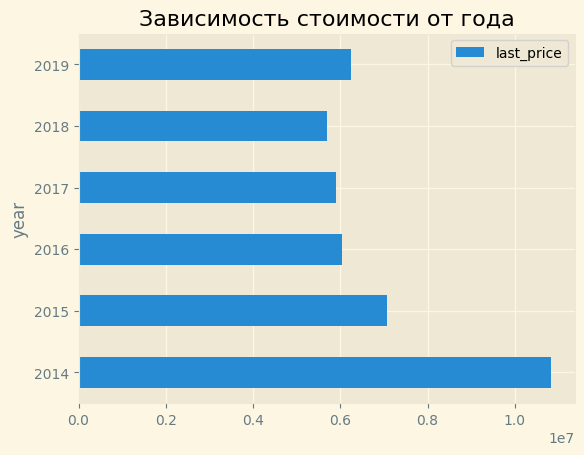

In [85]:
year_pivot = data.pivot_table(index='year', values='last_price', aggfunc='mean')
year_pivot.plot.barh(grid=True, title='Зависимость стоимости от года') ;

По этому графику довольно наглядно видно, что после 2014-го года стоимость стремительно падала, и только в 2019 начала выравниваться. Значения 2014 и 2017 годов расходятся почти в два раза.

Интересно, что могло повлиять на изменение стоимости. Предположим, что изменилась не столько стоимость, сколько площадь квартир. Посмотрим, как меняется медианная площадь продаваемых квартир в зависимости от года.

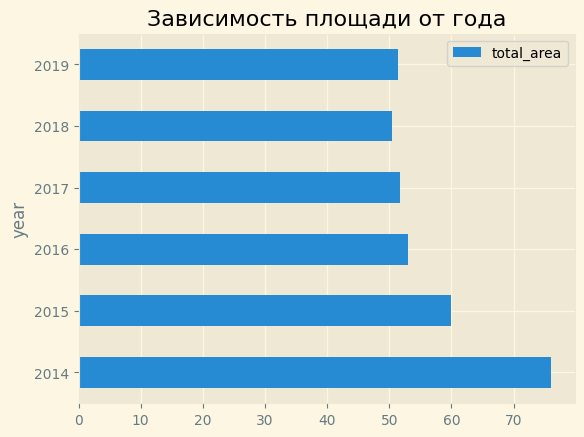

In [86]:
year_pivot_area = data.pivot_table(index='year', values='total_area', aggfunc='median')
year_pivot_area.plot.barh(grid=True, title='Зависимость площади от года');

Действительно, график изменения площади квартир очень похож на таковой со стоимостью. Выходит, площадь — всё ещё основной параметр, влияющий на общую стоимость.

Далее рассмотрим, как меняется стоимость в зависимости от месяца выставления объявления.

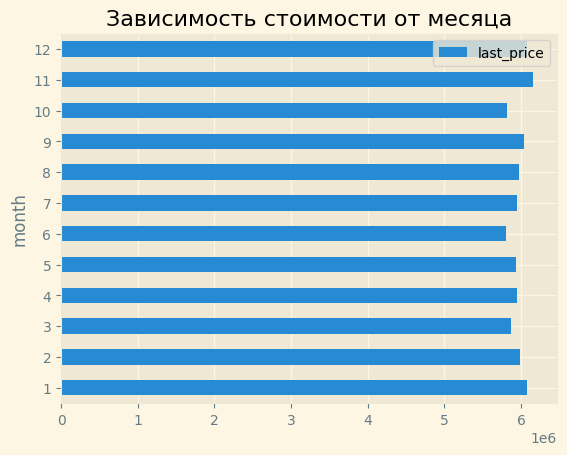

In [87]:
month_pivot = data.pivot_table(index='month', values='last_price', aggfunc='mean')
month_pivot.plot.barh(grid=True, title='Зависимость стоимости от месяца');

Как видим, больше всего стоимость объявлений в ноябре, на втором месте январь, на третьем — декабрь. Заметна тенденция, что более высокой стоимость квартир становится с приходом холодов. Самая низкая стоимость в июне и октябре.

Теперь посмотрим, оказывает ли влияние день недели, когда объявление было выставлено.

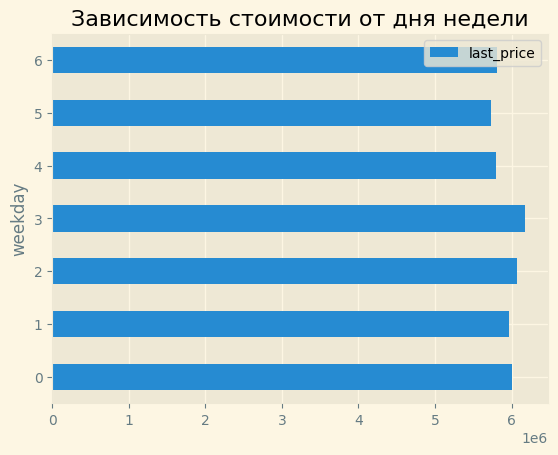

In [88]:
week_pivot = data.pivot_table(index='weekday', values='last_price', aggfunc='mean')
week_pivot.plot.barh(grid=True, title='Зависимость стоимости от дня недели');

Тут уже можно сказать, что пик стоимости приходится на вторник и среду. В пятницу и четверг же выставляется наиболее низкая цена.

##### Промежуточный вывод

Явное влияние на стоимость квартиры оказывает её площадь, жилая площадь, площадь кухни, а также количество комнат. Год выставления тоже имеет определённую корреляцию со стоимостью, но, как выяснилось при дальнейшем анализе, со временем менялась не столько стоимость, сколько размер продаваемых квартир. А вот месяц и день недели, когда объявление было выставлено, оказывают не настолько сильное влияние, чтобы опираться на них в каких-либо рассчётах.

#### Стоимость квадратного метра в десяти самых популярных населённых пунктах

Посчитаю стоимость одного квадратного метра в десяти самых часто встречающихся населённых пунктах.

В списке ниже представлены эти пункты и их медиана по стоимости:

In [89]:
top_locations = data.pivot_table(
    index='locality_name_cleared',
    values='meter_price',
    aggfunc=['count', 'median']).droplevel(1, axis=1)
top_locations = top_locations.sort_values(by='count', ascending=False).head(10)
top_locations.sort_values(by='count')

,count,median
locality_name_cleared,,
Выборг,235,58307.691406
деревня Кудрово,299,91860.468750
Гатчина,307,67796.609375
поселок Парголово,327,91642.859375
Колпино,337,74722.218750
Пушкин,368,99993.589844
Всеволожск,397,65789.476562
поселок Шушары,439,76829.257812
поселок Мурино,552,86059.296875


В виде таблицы не слишком наглядно. Построим график с изображением медианы:

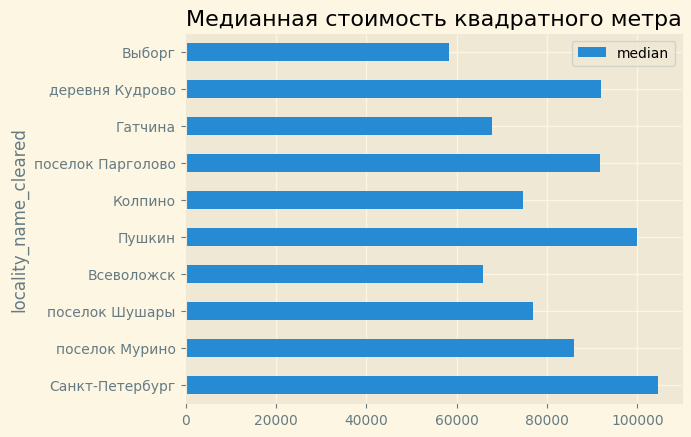

In [90]:
top_locations.drop('count', axis=1).plot.barh(grid=True, title='Медианная стоимость квадратного метра');

Как видно по данному графику, в Санкт-Петербурге средняя стоимость квадратного метра выше всего. На втором месте Пушкин, что тоже ожидаемо. Из популярных, самый дешёвый населённый пункт — это пограничный Выборг.

#### Стоимость квартир в Санкт-Петербурге по мере удалённости от центра

Сперва, выделим те квартиры, которые находятся в Санкт-Петербурге:

In [91]:
data_spb = data.loc[data['locality_name_cleared'] == 'Санкт-Петербург']
data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_category,locality_name_cleared,meter_price,weekday,month,year,floor_type,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,755.0,0,A,Санкт-Петербург,120370.367188,3,3,2019,Другой,16.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,574.0,558,C,Санкт-Петербург,92785.710938,3,8,2015,Другой,14.0
3,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,48.0,121,B,Санкт-Петербург,100000.000000,1,6,2018,Другой,8.0
6,5,7915000.0,71.599998,2019-04-18,2,2.65,24,41.000000,22,False,...,0.0,0,B,Санкт-Петербург,110544.703125,3,4,2019,Другой,12.0
8,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,0.0,289,C,Санкт-Петербург,88524.593750,6,2,2017,Другой,15.0


Теперь из полученного датасета сделаем сводную таблицу, которую сгруппируем по километрам от центра. Для каждого километра рассчитаем среднюю стоимость.

In [92]:
spb_pivot = data_spb.pivot_table(index='cityCenters_km', values='last_price', aggfunc='mean')
spb_pivot.shape

(30, 1)

Таблица довольно объёмная, в неё вошло 30 строк. Теперь посмотрим, как же меняется стоимость в зависимости от удалённости от центра города.

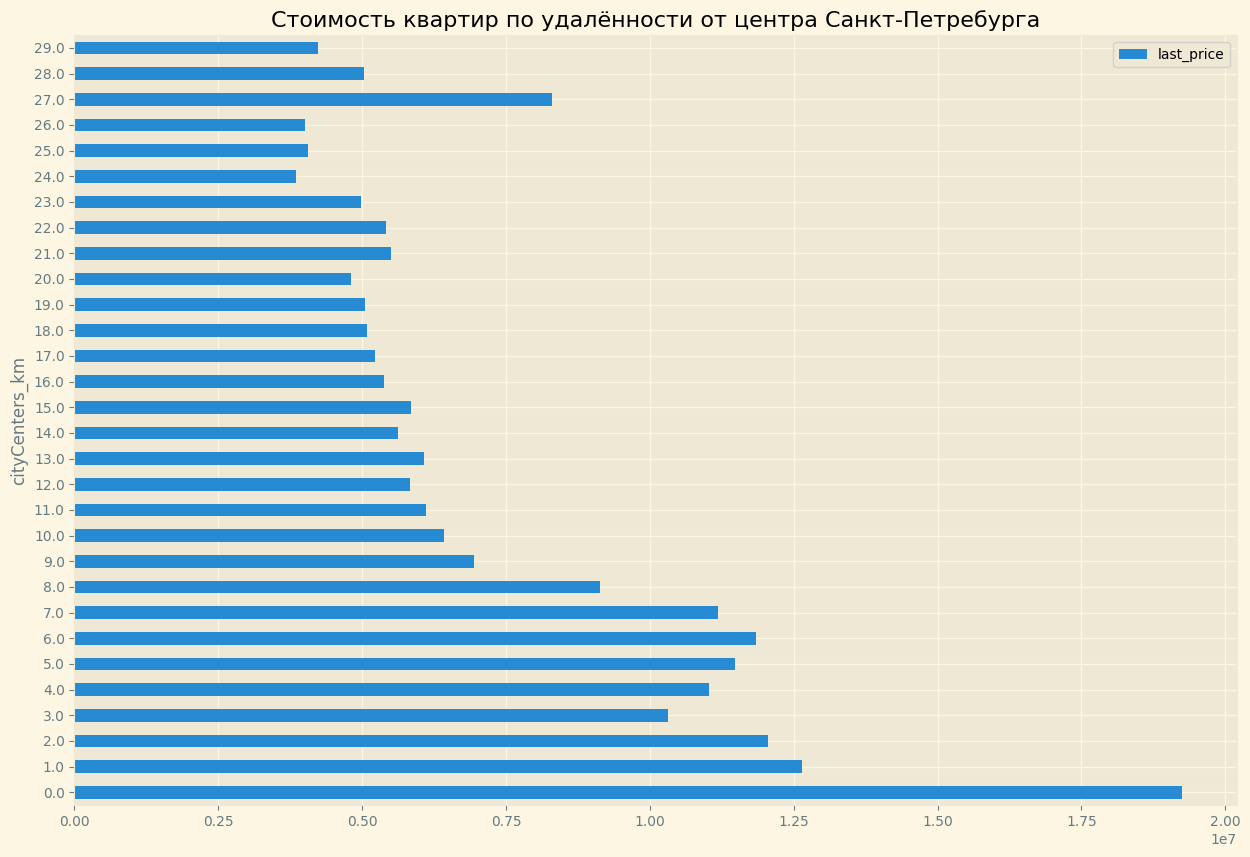

In [93]:
spb_pivot.plot.barh(figsize=(15, 10), grid=True, title = 'Стоимость квартир по удалённости от центра Санкт-Петребурга');

По графику видна зависимость: в среднем, стоимость в центре и рядом с ним значительно выше, чем на окраине. Хотя на удалении 27 км заметен скачок: возможно, там находится какой-то элитный жилой комплекс, который поднимает стоимость километра. Также примечателен подъём в районе шести километров, при том, что сразу после виден заметный спад. Наверняка примерно в этом месте заканчивается "старый" город и начинаются не такие популярные среди туристов места, а от того и менее дорогостоющие.

#### Промежуточный вывод

В данном пункте 4 я:
- Вывела и удалила аномальные значения, либо изменила те, которые можно было восстановить;
- Проанализировала с какой скоростью обычно продаются квартиры;
- Определила параметры, влияющие на стоимость квартиры;
- Составила рейтинг из населённых пунктов, в которых чаще всего продавали квартиры, а также выяснила медианную стоимость квадратного метра в каждом из них;
- Определила динамику изменения цены по мере удаления от центра в г. Санкт-Петербурге.


### Общий вывод

В данном проекте я рассматривала данные о продажах квартир в окрестностях Санкт-Петербурга за 2014-2019 года.

В п.2 я занималась предобработкой данных:
- Обработала пропущенные значения чтобы те не мешали дальнейшему анализу;
- Заменила тип столбца "first_day_exposition" с datetime на date, уменьшила объём занимаемой памяти у числовых значений;
- Обработала неявные дубликаты в столбце "locality_name", в котором хранятся названия населённых пунктов.

В п.3 я добавила несколько новых столбцов, которые в дальнейшем использовались для анализа, а именно:
- "meter_price" — Цена одного квадратного метра;
- "weekday" — День недели, в который объявление было опубликовано;
- "month" — Месяц публикации;
- "year" — Год публикации;
- "floor_type" — Тип этажа ("Первый", "Последний", "Другой");
- "cityCenters_km" — Расстояние до центра в километрах;

В п.4 проводила исследовательский анализ данных:
- Определяла и устраняла выбросы;
- Исследовала, сколько обычно объявления о продаже квартир лежали, пока их не покупали;
- Определяла факторы, влияющие на ценообразование;
- Выявила десять городов с наибольшим числом объявлений, а также сколько в среднем стоит квадратный метр в каждом из них;
- Подсчитала среднюю стоимость квартир в Санкт-Петербурге на каждый километр удалённости от центра города.

Проведённое исследование показало следующие результаты:
- 75% квартир продаются в пределах 196 дней с момента публикации.
- Общая площадь, также как и жилая и площадь кухни, оказывают прямое влияние на стоимость квартиры. То же с количеством комнат, этажом, годом публикации. А вот влияние месяца и дня недели публикации совсем незначительно.
- Из десяти самых популярных населённых пунктов, в Санкт-Петербурге больше всего публикаций и самая высокая стоимость квадратного метра. Выборг же, напротив, на десятом месте по обоим параметрам.
- Удалённость от центра в Санкт-Петербурге оказывает прямое влияние на стоимость жилья. При этом стоит отметить неравномерность: до семи километров средняя стоимость выше десяти миллионов, далее идёт стремительное падение, и на 27 километрах вновь редкий подъём до восьми миллионов.